In [1]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Installing networkx Library
!pip install networkx

In [3]:
#Importing Required Libraries
import networkx #For handling Network graphs
import random
import csv
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense,Input,Activation,BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import Normalizer
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils


In [4]:
#stroing dataset path
path='/content/drive/MyDrive/SENA/facebookdata.txt'

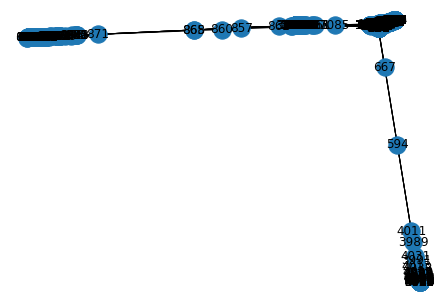

In [5]:
#Loading dataset into dataset as graph in variable
with open(path,'rb') as file:
  graph=networkx.read_edgelist(file)
networkx.draw_spectral(graph,with_labels = True)   

In [6]:
def Generate_False_Graph(Graph,neg_no):
  """
  Input : a graph as Networkx class
          number of negative samples
  Output :neg_no number of false edges (edges which does not exist in the graph)  
          and build a new graph using negative edges
  """
  Negative_graph= networkx.Graph() 
  count=0
  while (count<neg_no):

    [source,target]=random.sample(Graph.nodes(),2) # pick random two nodes in the graph

    try :

      short_path=networkx.shortest_path_length(Graph,source,target)
      if(short_path>=2):# there does not exist a direct edges betwwen them
         Negative_graph.add_edge(source,target, positive="False") # adding the false edges in the new graph created
         count += 1
    except:
       pass

  return Negative_graph                

In [7]:
def Extract_Sample(Graph,pos_no,neg_no):
  """
  Input : a graph as Networkx class
  Output : List of Positive and Negative samples
  """

  no_edges=Graph.number_of_edges()

  # Poistive samples

  pos_graph = networkx.Graph()
  positves=random.sample(Graph.edges(),pos_no)
  
  pos_graph.add_edges_from(positves, positive="True")
  networkx.write_edgelist(pos_graph, "positive_graph.txt", data=['positive'])

  # Negative Samples

  neg_graph=Generate_False_Graph(Graph,neg_no)
  networkx.write_edgelist(neg_graph, "negatvie_graph.txt", data=['positive'])

  return pos_graph.edges(),neg_graph.edges()


In [8]:
def common_neighbors(Graph, edges):
    """
    Input : graph as network class and edges
    Output: Common neigbors of the vertices connected by the given edge
    """
    result = []
    for edge in edges:
        src, dest = edge[0], edge[1]
        src_neighbor, dest_neighbor = set(Graph.neighbors(src)), set(Graph.neighbors(dest))
        count = len(src_neighbor.intersection(dest_neighbor))
        result.append((src, dest, count))
    return result

In [9]:
def Extract_feature(Graph,positives,negatives):
  """
  Input: Graph as network class
         Positive dataset(Nodes having edges among them)
         Negative Dataset(Nodes having shortest path greater than 2)
  Output:Features of the two nodes in the given dataset
         Features: Common Neighbours, Jacaard Coefficient, Resource allocation index, Adamic Adar Coefficient, Preferential Attachment
  """
  data = []
  feature_name = [common_neighbors,networkx.resource_allocation_index,networkx.jaccard_coefficient, networkx.adamic_adar_index, networkx.preferential_attachment]
  label = ["label"] + ["1" for i in range(len(positives))] + ["0" for i in range(len(negatives))]
  for func in feature_name:
    preds = func(Graph, positives)
    feature = [func.__name__] + [i[2] for i in preds]
    preds = func(Graph, negatives)
    feature = feature + [i[2] for i in preds]
    data.append(feature)
  data.append(label)
  col_names = []
  records = []
  for col in data:
    col_names.append(col[0])
    records.append(col[1:])
  records = np.array((records)).T
  csvfile = pd.DataFrame(records, columns = col_names).to_csv('features.csv')


In [10]:
#Extracting 5000 samples for each dataset
x,y=Extract_Sample(graph,10000,10000)

In [11]:
Extract_feature(graph, x, y)

In [12]:
dataset=pd.read_csv("features.csv")
x=dataset.iloc[:,1:-1].values
y=dataset.iloc[:,-1].values

In [13]:
def rand_hexcolor():
   """
   Input :None
   Output : Random color code in hexadecimal format
   Process:pick random number and convert ot hexadecimal
   """
  
   rgb = ""

   for _ in "RGB": # creating color for each channel
       i = random.randrange(0, 2**8)
       rgb += i.to_bytes(1, "big").hex()
   return '#'+rgb

In [16]:
numbercol

{0: '#17d7d0', 1: '#61752f'}

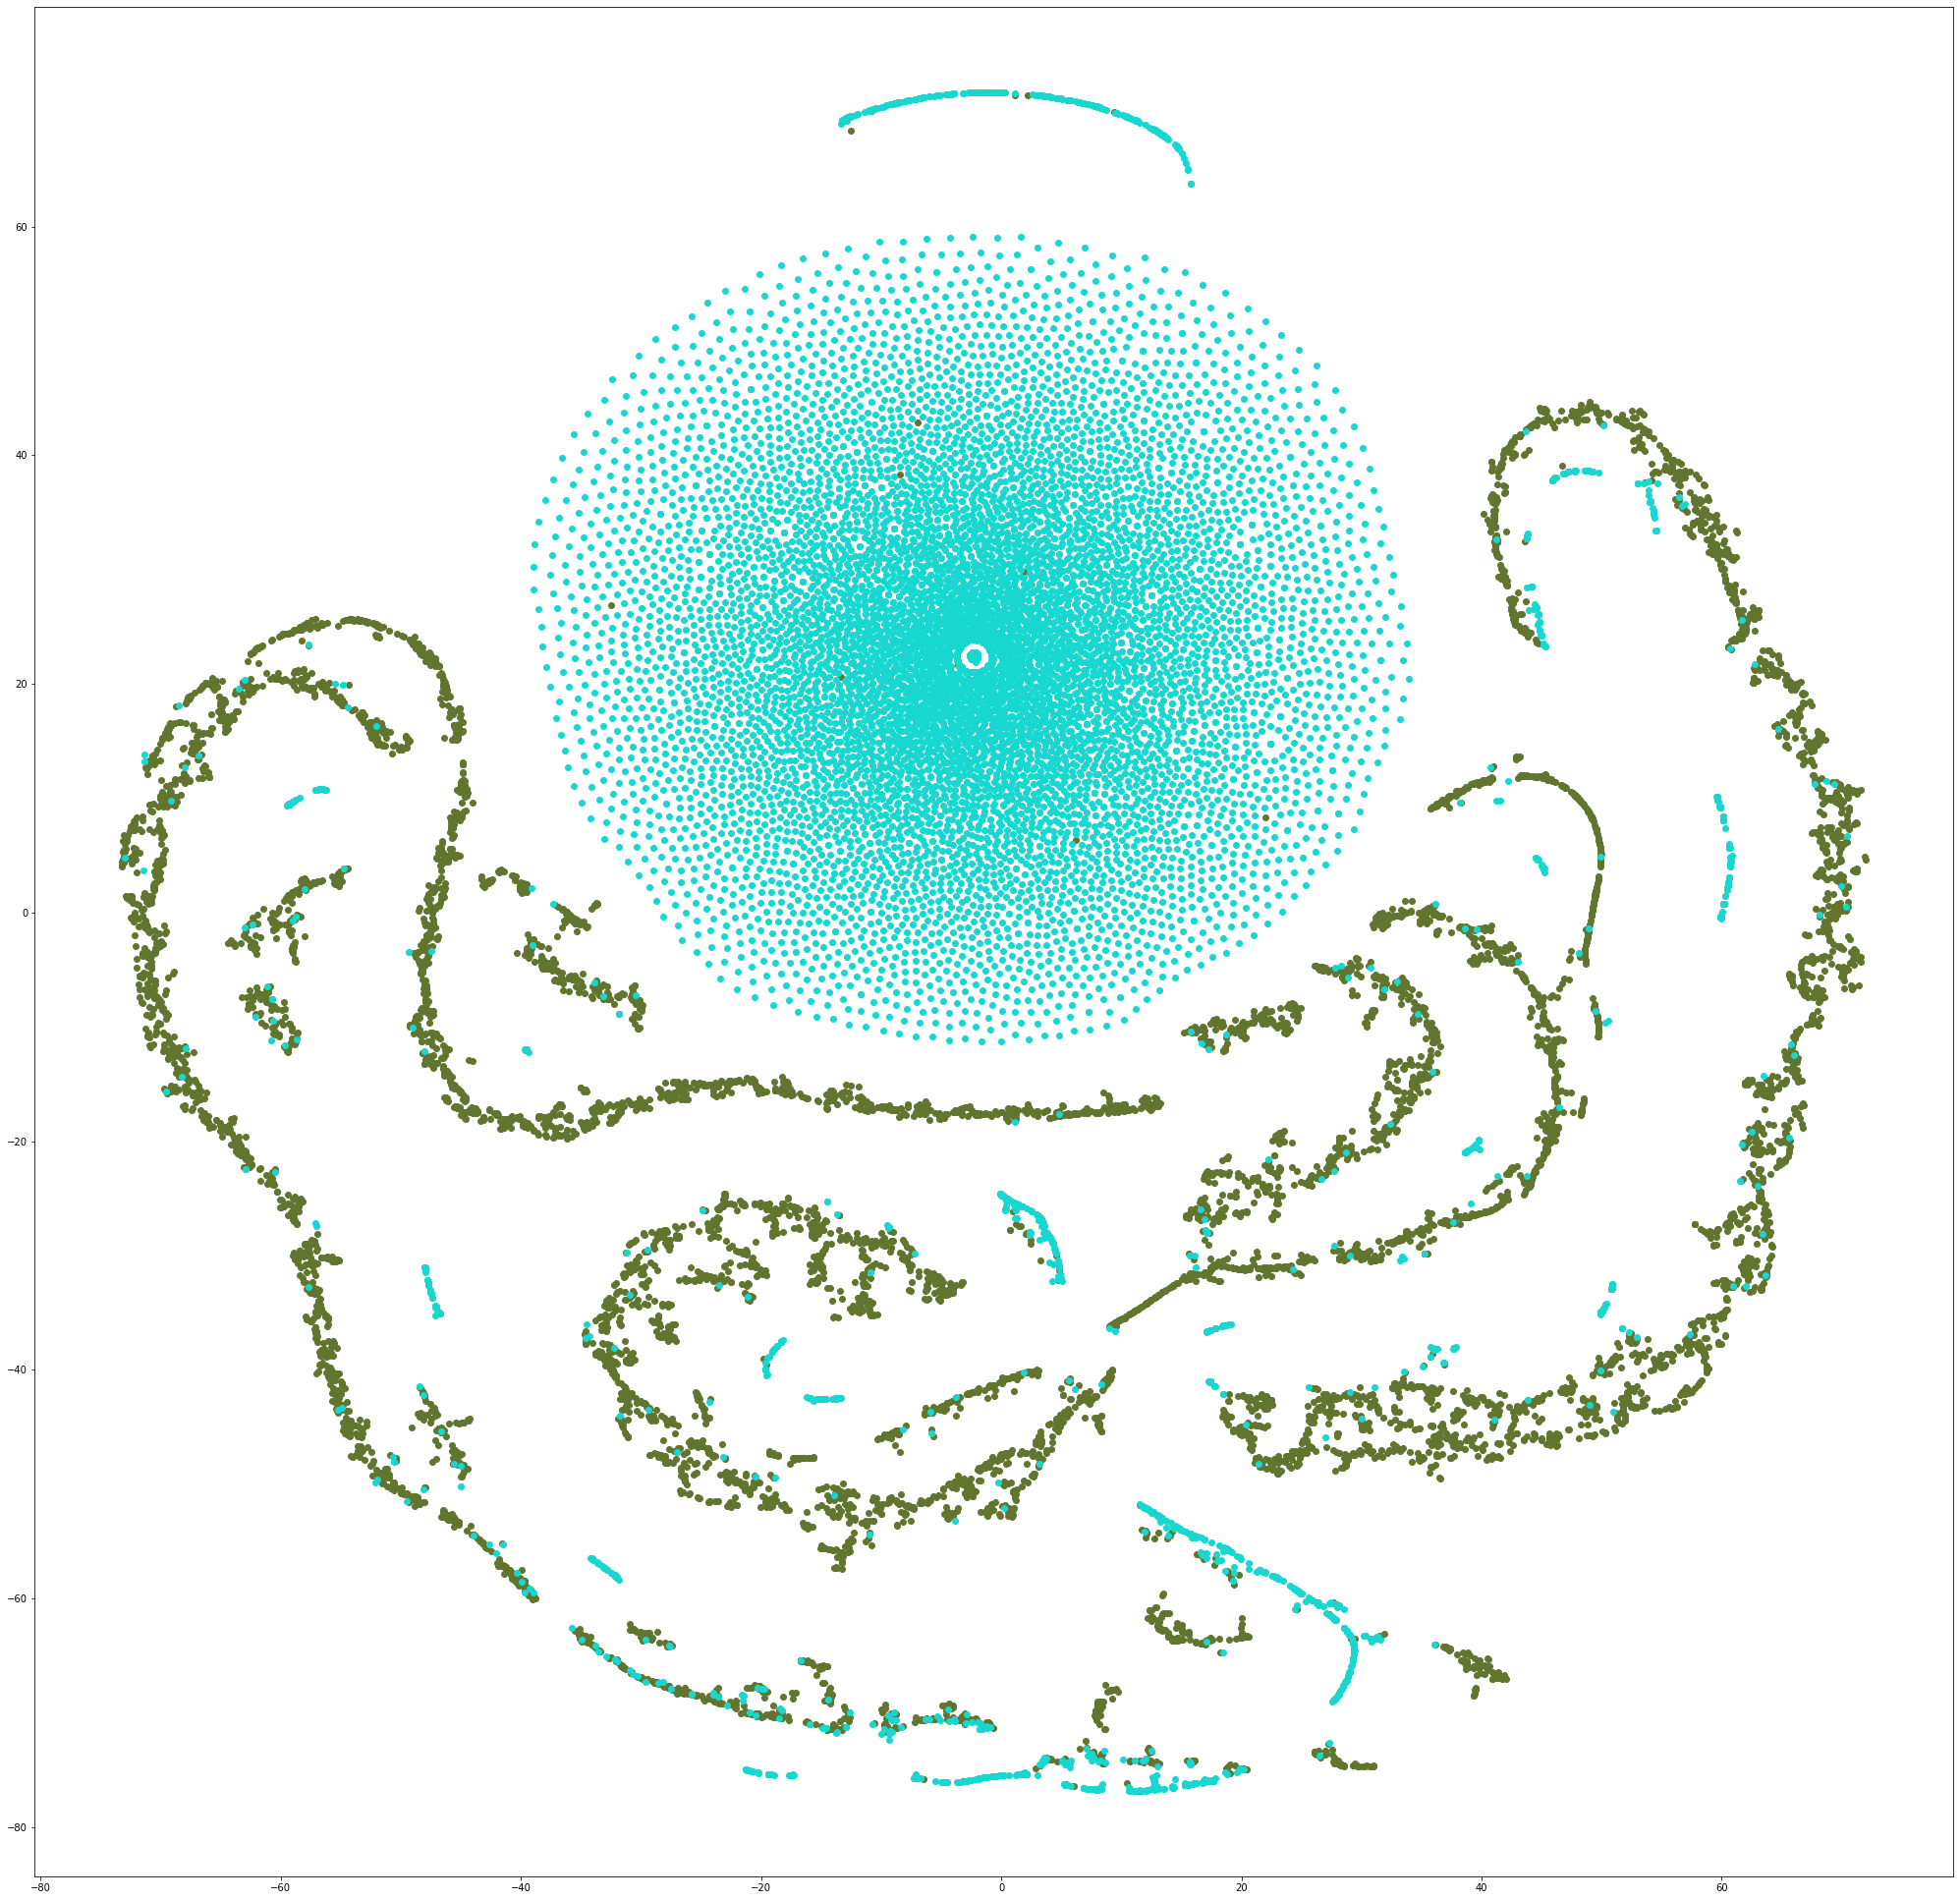

In [15]:
k=[0,1]
numbers=set(k.copy())
numbercol={i:rand_hexcolor() for i in numbers } # giving each number a color
    
from sklearn.manifold import TSNE # tsne converts the image to  dimensional feature vector which is used for plotting

# dimensionality reduction for viewing 400 dimesion hyperspace in 2d space    
tsne = TSNE(metric='cosine') # we use cosine metric which finds similarty between two feature vectors(pixels of the image)
embed_tsne = tsne.fit_transform(np.array((x))) # converting  400 feature
plt.figure(figsize=(35, 35)) # assigning size for each scatter plot

for idx in range(len(x)):# iterating through all training data
    plt.scatter(*embed_tsne[idx, :],c=numbercol[y[idx]]) # each point is marked in the  plot with tnse feature considering as coordinate with color chosen for that label corresponding to the record

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [ ]:
y_train = np_utils.to_categorical(y_train).astype('float32')
y_test = np_utils.to_categorical(y_test).astype('float32')

In [ ]:
y_train.shape

(13396, 2)

In [ ]:
#Building the base model
model = Sequential()
model.add(Input(len(x[0])))
model.add(BatchNormalization(axis=-1))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dense(2, activation='softmax'))

In [ ]:
#Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Model training
model.fit(X_train, y_train, batch_size=200, epochs=1000)

Epoch 1/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0660 - accuracy: 0.9783
Epoch 2/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0667 - accuracy: 0.9787
Epoch 3/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0664 - accuracy: 0.9788
Epoch 4/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0664 - accuracy: 0.9785
Epoch 5/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0660 - accuracy: 0.9795
Epoch 6/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0653 - accuracy: 0.9784
Epoch 7/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0672 - accuracy: 0.9780
Epoch 8/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0661 - accuracy: 0.9792
Epoch 9/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0661 - accuracy: 0.9782
Epoch 10/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0656 - accuracy: 0.9787

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_test,y_test)

207/207 [==============================] - 0s 2ms/step - loss: 0.0728 - accuracy: 0.9758


[0.07280298322439194, 0.975753903388977]

In [ ]:
model.save_weights('/content/drive/MyDrive/SENA/model.h5')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('/content/drive/MyDrive/SENA/model.h5')

In [ ]:
model.input

<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'input_5')>

In [ ]:
X = X_test[3000]
X = np.expand_dims(X, axis=0)

In [ ]:
np.argmax(model.predict(X))

0

In [ ]:
y_test[3000]

array([1., 0.], dtype=float32)